In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("apollo2506/eurosat-dataset")

print("Path to dataset files:", path)

100%|██████████| 2.04G/2.04G [00:23<00:00, 91.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/apollo2506/eurosat-dataset/versions/6


In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import random
from sklearn.ensemble import RandomForestClassifier

In [3]:
# Define the path to the EuroSAT dataset folder
dataset_path = path + "/EuroSAT"

# Get the names of the folders (representing classes) and sort them alphabetically
class_names = sorted([folder for folder in os.listdir(dataset_path)
                      if os.path.isdir(os.path.join(dataset_path, folder))])

# Print the list of class names
class_names

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [4]:
# Create a mapping from class names to numeric labels (e.g., Forest -> 0)
label_map = {name: idx for idx, name in enumerate(class_names)}

# Print the class-to-label mapping
label_map

{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

# CNN Model
---

In [5]:
# Initialize empty lists to store features (x_data) and labels (y_data)
x_data = []
y_data = []


# Loop through each class and read the images, resize them, and store with the corresponding label
for class_name in tqdm(class_names):
    class_folder = os.path.join(dataset_path, class_name)

    # Loop through each image in the class folder
    for img_name in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_name)

        # Read the image from the file path
        img = cv2.imread(img_path)

        # Check if the image was successfully read
        if img is not None:
            # Resize the image to 64x64
            img = cv2.resize(img, (32, 32))

            # Append the image to the feature list (x_data)
            x_data.append(img)

            # Append the corresponding class label to the label list (y_data)
            y_data.append(label_map[class_name])

100%|██████████| 10/10 [00:03<00:00,  2.67it/s]


In [6]:
# Convert the image data to a NumPy array and normalize pixel values to the range [0, 1]
x_data = np.array(x_data, dtype=np.float32) / 255.0

# Convert the label data to categorical format (one-hot encoding)
y_data = to_categorical(np.array(y_data), num_classes=len(class_names))

# Print the shape of the image data (number of images, height, width, channels)
print("Shape of images:", x_data.shape)

# Print the shape of the label data (number of images, number of classes)
print("Shape of labels:", y_data.shape)

Shape of images: (27000, 32, 32, 3)
Shape of labels: (27000, 10)


In [7]:
# Split the dataset into training and validation sets (14% for validation)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_data, y_data, test_size=0.14, random_state=42, stratify=y_data)

# The 'stratify' parameter ensures that the class distribution is similar in both training and validation sets

In [8]:
# Initialize the model as a Sequential model (stacked layers)
model = Sequential()

# Add a 2D convolutional layer with 32 filters, kernel size of (3, 3), and ReLU activation
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))

# Add another 2D convolutional layer with 64 filters and ReLU activation
model.add(Conv2D(64, (3, 3), activation='relu'))

# Add a max-pooling layer with pool size of (2, 2) to downsample the feature maps
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add a dropout layer with a rate of 0.25 to prevent overfitting
model.add(Dropout(0.25))

# Flatten the 3D feature maps into a 1D vector to feed into the fully connected layers
model.add(Flatten())

# Add a fully connected (dense) layer with 128 neurons and ReLU activation
model.add(Dense(128, activation='relu'))

# Add a dropout layer with a rate of 0.5 to further prevent overfitting
model.add(Dropout(0.5))

# Add the output layer with the number of neurons equal to the number of classes, and use softmax activation for multi-class classification
model.add(Dense(len(class_names), activation='softmax'))  # Use softmax for single-label

# Compile the model with categorical crossentropy loss, Adam optimizer, and accuracy as the evaluation metric
model.compile(loss='categorical_crossentropy',  # Use categorical_crossentropy for multi-class classification
              optimizer='adam',
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
# Train the model on the training data and validate on the validation data
history = model.fit(x_train, y_train,
                    batch_size=128,  # Set the batch size to 128
                    epochs=50,  # Train the model for 50 epochs
                    verbose=1,  # Display the training progress in the console
                    validation_data=(x_valid, y_valid))  # Use the validation data for evaluation during training

Epoch 1/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 85s 456ms/step - accuracy: 0.3310 - loss: 1.7882 - val_accuracy: 0.6091 - val_loss: 1.1330
Epoch 2/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 138s 437ms/step - accuracy: 0.5773 - loss: 1.2006 - val_accuracy: 0.6631 - val_loss: 0.9148
Epoch 3/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 82s 438ms/step - accuracy: 0.6617 - loss: 0.9724 - val_accuracy: 0.7636 - val_loss: 0.6917
Epoch 4/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 82s 443ms/step - accuracy: 0.7135 - loss: 0.8298 - val_accuracy: 0.7284 - val_loss: 0.7748
Epoch 5/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 82s 444ms/step - accuracy: 0.7273 - loss: 0.7808 - val_accuracy: 0.7702 - val_loss: 0.6539
Epoch 6/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 78s 425ms/step - accuracy: 0.7458 - loss: 0.7245 - val_accuracy: 0.7662 - val_loss: 0.6443
Epoch 7/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 84s 437ms/step - accuracy: 0.7552 - loss: 0.6999 - val_accuracy: 0.8030 - val_loss: 0.5639
Epoch 8/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 79s 419ms/step - accuracy: 0.7770 - loss: 

119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step

📋 Classification Report for CNN Model:

                      precision    recall  f1-score   support

          AnnualCrop       0.89      0.87      0.88       420
              Forest       0.95      0.96      0.95       420
HerbaceousVegetation       0.81      0.76      0.79       421
             Highway       0.69      0.71      0.70       350
          Industrial       0.89      0.91      0.90       350
             Pasture       0.80      0.87      0.83       280
       PermanentCrop       0.76      0.68      0.72       350
         Residential       0.88      0.97      0.92       420
               River       0.80      0.77      0.79       350
             SeaLake       0.98      0.97      0.98       420

            accuracy                           0.85      3781
           macro avg       0.85      0.85      0.85      3781
        weighted avg       0.85      0.85      0.85      3781


📌 Confusion Matrix for CNN Model:


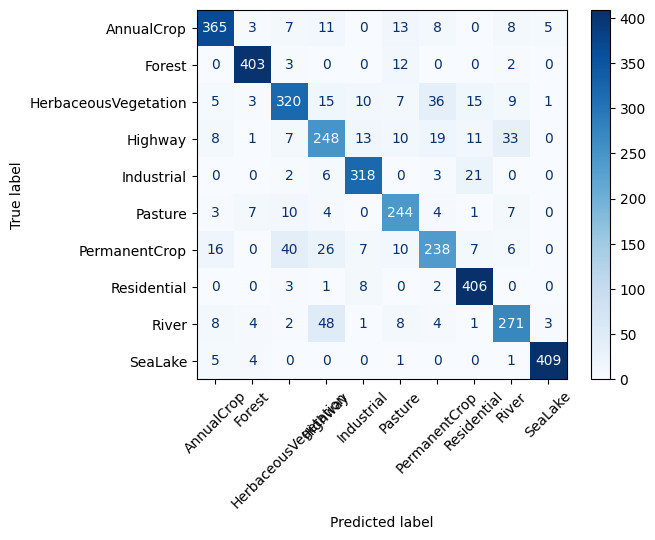

In [10]:
# Make predictions on the validation set using the trained CNN model
y_pred_cnn = model.predict(x_valid)

# Convert the predicted probabilities to class labels
y_pred_cnn = np.argmax(y_pred_cnn, axis=1)  # Get the index of the max probability for each prediction

# Convert the true labels to the same format (class indices)
y_valid_cnn = np.argmax(y_valid, axis=1)

# Print the classification report showing precision, recall, and F1-score for each class
print("\n📋 Classification Report for CNN Model:\n")
print(classification_report(y_valid_cnn, y_pred_cnn, target_names=class_names))

# Compute the confusion matrix to evaluate the accuracy of the CNN model's predictions
cm_cnn = confusion_matrix(y_valid_cnn, y_pred_cnn)

# Display the confusion matrix with class labels
disp_cnn = ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels=class_names)

# Print and plot the confusion matrix
print("\n📌 Confusion Matrix for CNN Model:")
disp_cnn.plot(xticks_rotation=45, cmap="Blues")
plt.show()

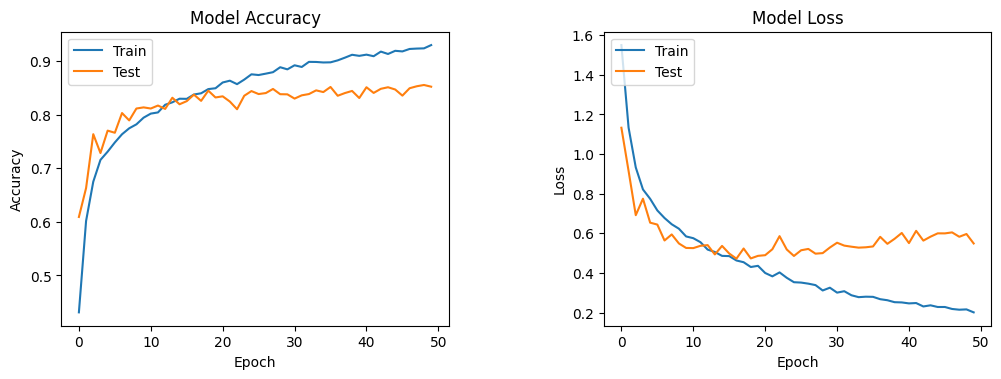

In [11]:
# Plot model accuracy and loss for both training and validation data

# Create a figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 3), sharey=False)

# Adjust the spacing between subplots
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.4)

# Plot training and validation accuracy
axs[0].plot(history.history['accuracy'])  # Plot training accuracy
axs[0].plot(history.history['val_accuracy'])  # Plot validation accuracy
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Test'], loc='upper left')

# Plot training and validation loss
axs[1].plot(history.history['loss'])  # Plot training loss
axs[1].plot(history.history['val_loss'])  # Plot validation loss
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Test'], loc='upper left')

# Show the plots
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


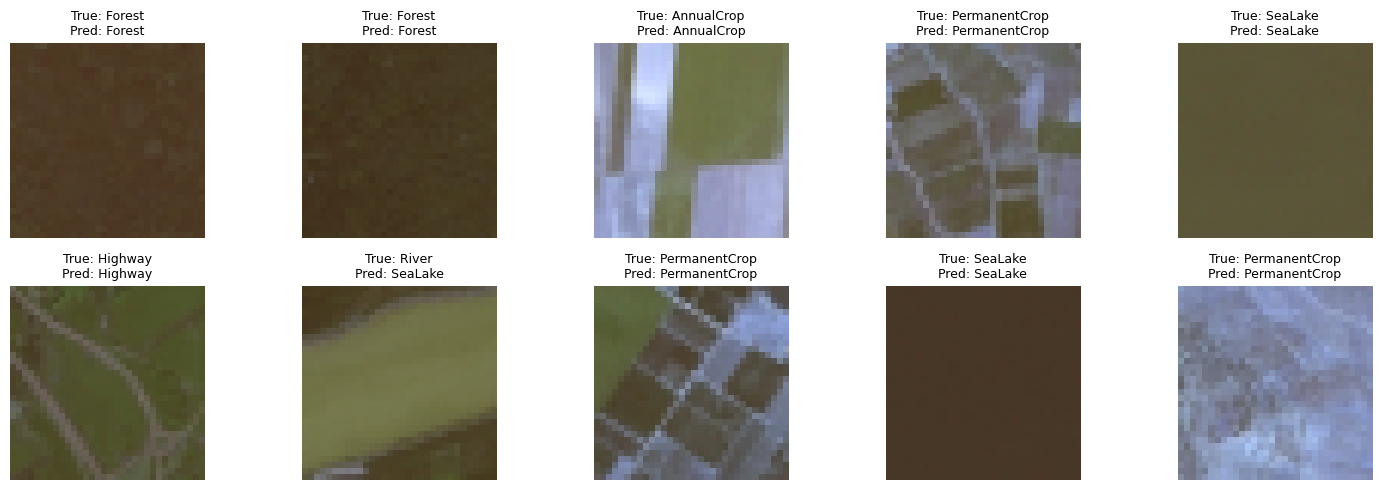

In [12]:
# Display 10 random images from the validation set along with their true and predicted labels for the CNN model

# Randomly select 10 indices from the validation set
indices = random.sample(range(len(x_valid)), 10)

# Create a figure to display the images
plt.figure(figsize=(15, 5))

# Loop through the selected indices to display each image and its true and predicted labels
for i, idx in enumerate(indices):
    # Reshape the image to its original shape
    img = x_valid[idx]

    # Get the true label and predicted label for the image
    true_label = class_names[np.argmax(y_valid[idx])]  # True label from one-hot encoded labels
    pred_label = class_names[np.argmax(model.predict(np.expand_dims(x_valid[idx], axis=0)))]  # Predicted label from CNN model

    # Display the image in a subplot
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=9)  # Display true and predicted labels
    plt.axis('off')  # Turn off axis labels for better visualization

# Adjust layout to ensure everything fits
plt.tight_layout()
# Show the plot
plt.show()

# Random Forest model
---

In [15]:
# Initialize empty lists to store features (x_data) and labels (y_data)
x_data = []
y_data = []

# Loop through each class and read the images, resize them, and store with the corresponding label
for class_name in tqdm(class_names):
    class_folder = os.path.join(dataset_path, class_name)

    # Loop through each image in the class folder
    for img_name in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_name)

        # Read the image from the file path
        img = cv2.imread(img_path)

        # Check if the image was successfully read
        if img is not None:
            # Resize the image to 64x64
            img = cv2.resize(img, (64, 64))

            # Append the image to the feature list (x_data)
            x_data.append(img)

            # Append the corresponding class label to the label list (y_data)
            y_data.append(label_map[class_name])

100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


In [16]:
# Convert image data to a NumPy array and normalize pixel values to the range [0, 1]
X = np.array(x_data, dtype=np.float32) / 255.0  # Normalized

# Convert label data to a NumPy array
y = np.array(y_data)

# Print the total number of images in the dataset
print("Number of images:", X.shape[0])

# Print the shape of each image (height, width, channels)
print("Shape of each image:", X.shape[1:])

# Print the total number of unique classes (categories)
print("Number of classes:", len(class_names))

Number of images: 27000
Shape of each image: (64, 64, 3)
Number of classes: 10


In [17]:
# Convert the images into the required format for RandomForest (flattening the image)
# Flatten the images to a shape of (samples, number of features) to work with RandomForest
X_flat = X.reshape((X.shape[0], -1))  # Flatten the images (from 3D to 2D)

In [18]:
# Split the flattened dataset into training and validation sets (40% for validation)
X_train, X_validation, y_train, y_validation = train_test_split(
    X_flat, y, test_size=0.40, random_state=42, stratify=y)

# Print the shape of the training and validation sets for both features and labels
print('X_train shape:', X_train.shape)  # Shape of the training features
print('X_validation shape:', X_validation.shape)  # Shape of the validation features
print('y_train shape:', y_train.shape)  # Shape of the training labels
print('y_validation shape:', y_validation.shape)  # Shape of the validation labels

X_train shape: (16200, 12288)
X_validation shape: (10800, 12288)
y_train shape: (16200,)
y_validation shape: (10800,)


In [19]:
# Initialize the RandomForestClassifier with specified hyperparameters
rf = RandomForestClassifier(
    n_estimators=300,  # Number of trees in the forest
    max_features='sqrt',  # Use the square root of the total number of features for each tree
    bootstrap=True,  # Use bootstrapping (sampling with replacement) for training trees
    oob_score=True,  # Use out-of-bag samples to estimate the generalization accuracy
    n_jobs=-1,  # Use all available CPU cores for parallel processing
    random_state=42,  # Set a random seed for reproducibility
    class_weight='balanced_subsample'  # Adjust weights inversely proportional to class frequencies in each bootstrap sample
)

# Train the Random Forest model on the training data
rf.fit(X_train, y_train)

# Print a success message indicating that the model has been trained
print('✅ Model trained successfully.')

✅ Model trained successfully.


In [20]:
# Print the Out-Of-Bag (OOB) score which is an internal estimate of model performance
print('📊 OOB Score (Internal Estimation):', rf.oob_score_)

📊 OOB Score (Internal Estimation): 0.6598765432098765



📋 Classification Report:

                      precision    recall  f1-score   support

          AnnualCrop       0.63      0.71      0.66      1200
              Forest       0.83      0.91      0.87      1200
HerbaceousVegetation       0.61      0.56      0.58      1200
             Highway       0.52      0.28      0.36      1000
          Industrial       0.74      0.88      0.80      1000
             Pasture       0.70      0.76      0.73       800
       PermanentCrop       0.52      0.41      0.46      1000
         Residential       0.57      0.69      0.63      1200
               River       0.62      0.66      0.64      1000
             SeaLake       0.94      0.91      0.92      1200

            accuracy                           0.68     10800
           macro avg       0.67      0.68      0.67     10800
        weighted avg       0.67      0.68      0.67     10800


📌 Confusion Matrix:


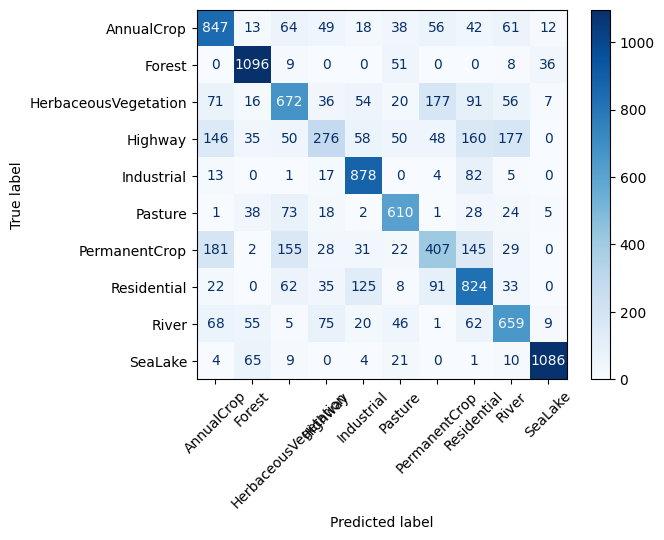

In [21]:
# Make predictions on the validation set using the trained Random Forest model
y_pred = rf.predict(X_validation)

# Print the classification report showing precision, recall, and F1-score for each class
print("\n📋 Classification Report:\n")
print(classification_report(y_validation, y_pred, target_names=class_names))

# Compute the confusion matrix to evaluate the accuracy of the model's predictions
cm = confusion_matrix(y_validation, y_pred)

# Display the confusion matrix with class labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Print and plot the confusion matrix
print("\n📌 Confusion Matrix:")
disp.plot(xticks_rotation=45, cmap="Blues")
plt.show()

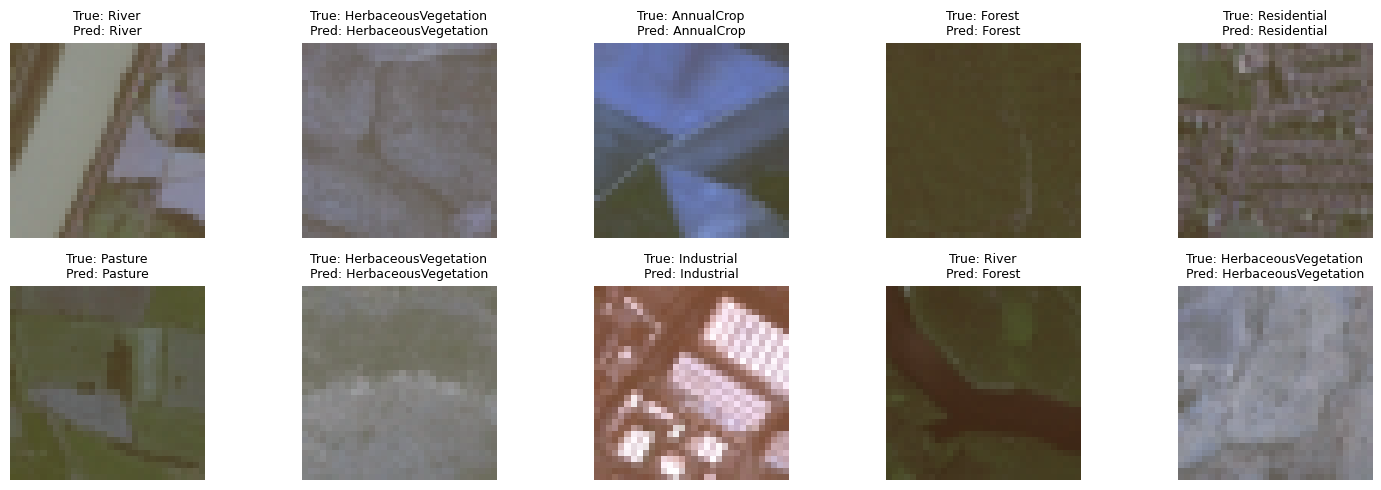

In [23]:
# Display 10 random images from the validation set along with their true and predicted labels

# Randomly select 10 indices from the validation set
indices = random.sample(range(len(x_valid)), 10)

# Create a figure to display the images
plt.figure(figsize=(15, 5))

# Loop through the selected indices to display each image and its true and predicted labels
for i, idx in enumerate(indices):
    # Reshape the image to its original shape
    img = x_valid[idx].reshape(32, 32, 3)

    # Get the true label and predicted label for the image
    true_label = class_names[np.argmax(y_valid[idx])]  # True label from one-hot encoded labels
    pred_label = class_names[y_pred_cnn[idx]]  # Predicted label from the model's predictions

    # Display the image in a subplot
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=9)  # Display true and predicted labels
    plt.axis('off')  # Turn off axis labels for better visualization

# Adjust layout to ensure everything fits
plt.tight_layout()
# Show the plot
plt.show()